In [18]:
!pip freeze > requirements.txt

In [4]:
from data_processing.processing import nlp, visualize_ent, visualize_dep, load_xls
from data_processing.feature_extraction import contains_cancer, contains_symptoms, has_question, count_ents, contains_goals
from data_processing.generate_data import gen_df, gen_cq, gen_cq_gemini
import pandas as pd
df, dfcq = load_xls('raw_data\Palliative Care Consult Orders V2.xlsx', "CLINICAL_DISPLAY_LINE")

### Todo list:

- add columns for various other diagnosis types (goals, pulm, cardiac, renal, GI, other?) - will require expansion of rulesets
- ~~figure out how to use Gemini API to generate questions (for free)~~
- After finishing the rulesets, can analyze the generation of consult quetsions with and without a more structured instruction/weighting.
- Start writing. Three blog posts
    - Generating the structured data
    - Generating consult questions
    - Intro to MedSpacy for generation of structured data from unstructured text
- Dashboard to play with it?

DO ALL THE ABOVE BUT WITH THE CONSULT FORMAT FOR CPQC



# Extracting existing data into PCQC

Problems:

-referral service, no easy way to differentiate between resident subspecialties without mapping all physicians at baystate... it's doable, but would take a while and need to be updated annually.
    -Can get more information from location (i.e. icu)

-drop any non-complete consults? I'm assuming they won't be going to the dataset

-include context in the entity extraction logic?
    -yes, maybe not negation, but historical diagnoses?

-clean up dtypes

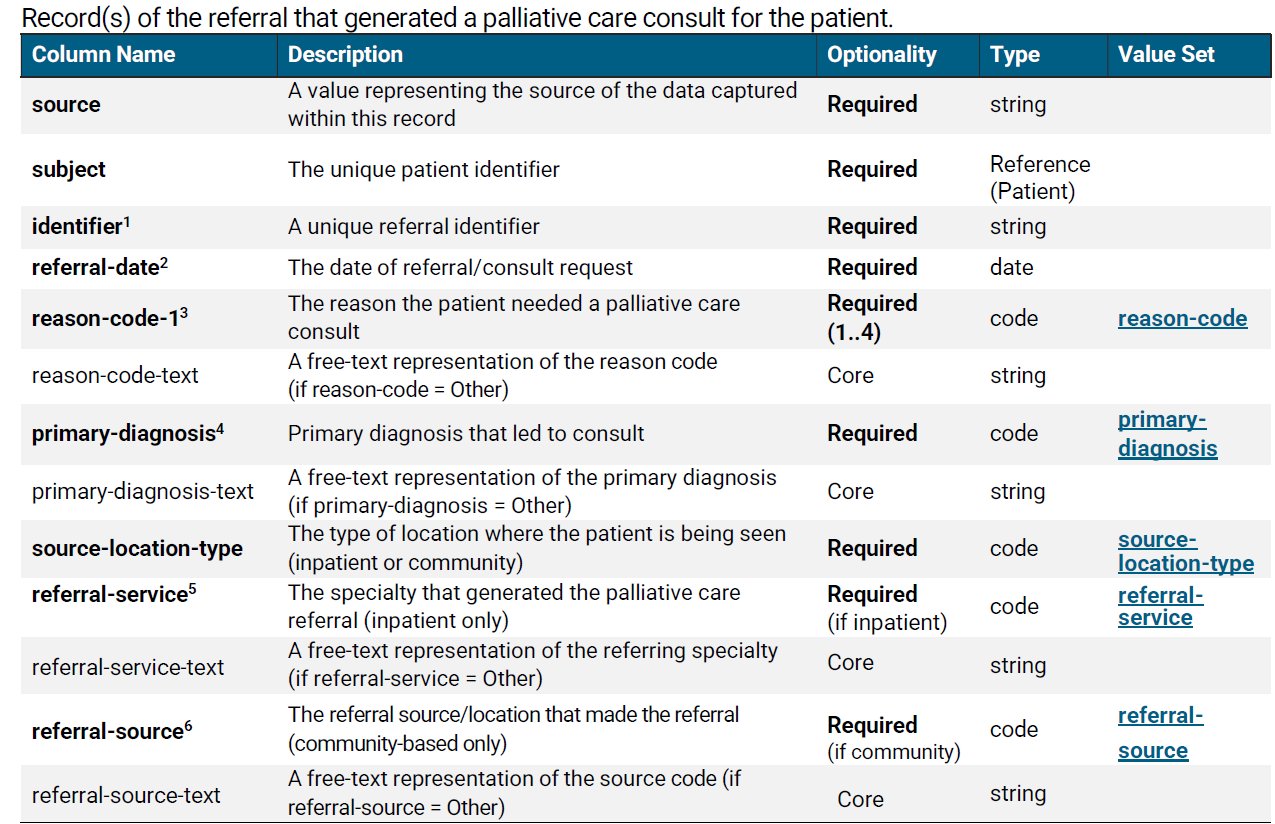

In [1]:
import referral.RDS as rds
from data_processing.processing import nlp, visualize_ent, visualize_dep, load_xls
from data_processing.feature_extraction import contains_cancer, contains_symptoms, has_question, count_ents, contains_goals
from data_processing.generate_data import gen_df, gen_cq, gen_cq_gemini
import pandas as pd


In [2]:
df, dfcq = load_xls('raw_data\Palliative Care Consult Orders V2.xlsx', "CLINICAL_DISPLAY_LINE")
print(df.shape)
df.head(5)


(2155, 20)


,DOMAIN,ORIG_ORDER_DT_TM,ORDER_ID,FIN,FACILITY,LOCATION,STATUS,CATALOG_CD,CATALOG_CD.1,ORDERED_AS_MNEMONIC,CLINICAL_DISPLAY_LINE,PATIENT,ABS_BIRTH_DT_TM,ORDER_ENTERED_IN_APP,ORDER_ENTERED_BY,ORDER_ENTERED_BY_POSITION,ORDER_ENTERED_BY_USERNAME,ORDERING_DOC,ORDERING_DOC_POSITION,ORDERING_DOC_USERNAME
0,P627,2023-12-22 14:00:19,8200019437,862732881,BMC,A,Ordered,506157494,Consult Palliative Care,Consult Palliative Care,"Consult-Follow-Up Until Problem Resolved, for ...","GONZALEZ, ANA",1941-11-08 19:00:00,HNA: Powerchart,"Timilsina MD, Sanjay",BHS Physician - Hospital Medicine,EN101331,"Timilsina MD, Sanjay",BHS Physician - Hospital Medicine,EN101331
1,P627,2023-12-22 12:08:24,8199762529,862866184,BMC,53,Ordered,506157494,Consult Palliative Care,Consult Palliative Care,"Consultation, seen earlier this month by your ...","CRUZADO, MARGARITA",1950-02-08 19:00:00,HNA: Powerchart,"Workman MD, Sarah",BHS Physician - Hospital Medicine,EN10679,"Workman MD, Sarah",BHS Physician - Hospital Medicine,EN10679
2,P627,2023-12-22 11:31:32,8199683245,862866838,BMC,50,Ordered,506157494,Consult Palliative Care,Consult Palliative Care,"Consultation, GOC, advacned HCC now with carci...","PACHECO GONZALEZ, OLGA",1965-08-31 20:00:00,HNA: Powerchart,"Ferig Sr MD, Mina A",BHS Physician - Hospital Medicine,EN31201,"Ferig Sr MD, Mina A",BHS Physician - Hospital Medicine,EN31201
3,P627,2023-12-22 07:40:34,8199055433,862865020,BMC,HVCC,Completed,506157494,Consult Palliative Care,Consult Palliative Care,"Consultation, patient CMO, palliative consult ...","GIANFELICE, ELIZABETH",1960-12-03 19:00:00,Server: Order Process Server,"Cheng MD, Justine",BHS Resident,EN103390,"Cheng MD, Justine",BHS Resident,EN103390
4,P627,2023-12-21 18:37:54,8197886679,660399139,BMC,B,Ordered,506157494,Consult Palliative Care,Consult Palliative Care,"Consult-Follow-Up Until Problem Resolved, sign...","KOS, DEAN",1962-06-28 20:00:00,HNA: Powerchart,"Chin MD, Thomas Yew Chye",BHS Physician - Hospital Medicine,EN18359,"Chin MD, Thomas Yew Chye",BHS Physician - Hospital Medicine,EN18359


In [3]:
transformer = rds.ReferralDataTransformer(df, 99999)
df = transformer.transform()

ERROR:referral.reason_extract:An error occurred during NLP processing: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
ERROR:referral.ExtractProblem:An error occurred during NLP processing: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


In [4]:
print(df.shape)
df.head(10)

(2155, 10)


,source,subject,identifier,referral-date,reason-code-1,reason-code-2,reason-code-3,primary-diagnosis,source-location-type,referral-service
0,99999,862732881,8200019437,2023-12-22,2,<NA>,<NA>,3,inpatient,2.0
1,99999,862866184,8199762529,2023-12-22,1,<NA>,<NA>,99,inpatient,2.0
2,99999,862866838,8199683245,2023-12-22,2,<NA>,<NA>,1,inpatient,2.0
3,99999,862865020,8199055433,2023-12-22,2,<NA>,<NA>,1,inpatient,16.0
4,99999,660399139,8197886679,2023-12-21,2,<NA>,<NA>,11,inpatient,2.0
5,99999,862863470,8197297951,2023-12-21,2,<NA>,<NA>,99,inpatient,2.0
6,99999,862786648,8197080607,2023-12-21,2,<NA>,<NA>,8,inpatient,16.0
7,99999,862850469,8196891799,2023-12-21,2,<NA>,<NA>,1,inpatient,2.0
8,99999,862814036,8196855091,2023-12-21,1,2,<NA>,6,inpatient,2.0
9,99999,862812089,8196654029,2023-12-21,3,<NA>,<NA>,3,inpatient,2.0


In [5]:
all_reason_codes = pd.concat([df['reason-code-1'], df['reason-code-2'], df['reason-code-3']])
value_counts = all_reason_codes.value_counts()
print(value_counts)

2    1247
4     768
1     199
3     173
Name: count, dtype: int64


In [6]:
df['primary-diagnosis'].value_counts()

primary-diagnosis
99    1318
1      367
3      174
7       56
4       53
10      43
9       39
8       36
6       22
5       20
2       10
12       8
11       7
13       1
15       1
Name: count, dtype: int64

In [9]:
#save df to xlsx
df.to_excel('processed_data\palliative_care_consult_orders.xlsx', index=False)

# Parsing out the problem code

In [3]:
from referral.ExtractProblem import ProbExtraction

In [5]:
test = ProbExtraction(df.iloc[20])
test.show_primary()

'unknown'

# Parsing out Reason Code

1 - symptoms

2 - decisions

3 - support

4 - unknown

99 - write in

In [35]:
#defining the doc_consumer, which extracts entities and details from the nlp generated doc for each consult_question
doc_consumer = DocConsumer(nlp, dtypes=("ents", "doc"), 
                            dtype_attrs={
                                "ents": [
                                    "text",
                                    "label_",
                                    "problem_type",
                                    "treatment_type",
                                    "is_negated",
                                    "is_uncertain",
                                    "is_historical",
                                    "is_hypothetical",
                                    "is_family",
                                    
                                ],
                                "doc":
                                ["text", 
                                 #"report_title"
                                 ]
                                
                            }
)

class EntExtraction:
    def __init__(self, row):
        try:
            self.doc = nlp(row['CLINICAL_DISPLAY_LINE'])
        except KeyError:
            print("KeyError: 'CLINICAL_DISPLAY_LINE' not found in the provided row.")
            self.doc = nlp('')  # Create an empty document
        except Exception as e:
            print(f"An error occurred during NLP processing: {e}")
            self.doc = nlp('')  # Create an empty document

    def _doc_consumer(self):
        self.dc = doc_consumer(self.doc)
        self.dcdf = self.dc._.to_dataframe()

    def _categories(self):
        self._doc_consumer()
        self.categories = self.dcdf['treatment_type'] + self.dcdf['problem_type']

    def reason_codes(self):
        self._categories()
        codes = []
        # Map categories to codes
        if 'symptom' in self.categories.values:
            codes.append(1)  # Replace with actual codes
        if 'goals' in self.categories.values:
            codes.append(2)
        if 'support' in self.categories.values:
            codes.append(3)
        # Fill remaining slots with NaN or default values
        while len(codes) < 3:
            codes.append(float('nan'))  # or some default value
        #if codes contains nothing but nan, then set the first value to 4
        if all([pd.isnull(code) for code in codes]):
            codes[0] = 4
        return codes

### Everything down here is just for testing###
    def show_doc(self):
        try:
            print(self.doc.text)
        except AttributeError:
            print("NLP document is not initialized properly.")

    def show_dcdf(self):
        self._doc_consumer()
        return self.dcdf.head(10)
    
    def show_categories(self):
        self._categories()
        return self.categories


In [29]:
test = EntExtraction(df.iloc[38])
test.show_categories()


0     cancer
1     cancer
2     cancer
3    symptom
dtype: object

In [32]:
test = EntExtraction(df.iloc[38])
test.reason_codes()

[1, nan, nan]

In [34]:
df.head(25)

,source,subject,identifier,referral-date,CLINICAL_DISPLAY_LINE,source-location-type,referral-service,reason-code-1,reason-code-2,reason-code-3
0,99599,862732881,8200019437,2023-12-22,"Consult-Follow-Up Until Problem Resolved, for ...",inpatient,2.0,2,NaN,NaN
1,99599,862866184,8199762529,2023-12-22,"Consultation, seen earlier this month by your ...",inpatient,2.0,1,NaN,NaN
2,99599,862866838,8199683245,2023-12-22,"Consultation, GOC, advacned HCC now with carci...",inpatient,2.0,2,NaN,NaN
3,99599,862865020,8199055433,2023-12-22,"Consultation, patient CMO, palliative consult ...",inpatient,1.0,2,NaN,NaN
4,99599,660399139,8197886679,2023-12-21,"Consult-Follow-Up Until Problem Resolved, sign...",inpatient,2.0,4,NaN,NaN
5,99599,862863470,8197297951,2023-12-21,"Consult-Follow-Up Until Problem Resolved, goal...",inpatient,2.0,2,NaN,NaN
6,99599,862786648,8197080607,2023-12-21,"Consultation, Lady with dementia. Plan to comp...",inpatient,1.0,2,NaN,NaN
7,99599,862850469,8196891799,2023-12-21,"Consultation, Obstructive biliary carcinoma. ...",inpatient,2.0,2,NaN,NaN
8,99599,862814036,8196855091,2023-12-21,"Consultation, h/o cholangiocarcinoma, cirrhosi...",inpatient,2.0,1,2.0,NaN
9,99599,862812089,8196654029,2023-12-21,"Consultation, difficult totreat afib , failure...",inpatient,2.0,4,NaN,NaN


An error occurred during NLP processing: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


In [43]:
text = df['CLINICAL_DISPLAY_LINE'].iloc[38] #change to row variable
print('text: ', text)
doc = nlp(text)
print('doc: ', doc.text) #REMOVE
doc = doc_consumer2(doc)
docdf = doc._.to_dataframe()
print(docdf.head(5)) # REMOVE
categories = docdf['treatment_type'] + docdf['problem_type']
print('categories: ', categories) # remove

text:  Consultation, stage IV uroepithelial bladder cancer who presents with a metastatic small bowel obstruction, 12/17/23 7:55:00 EST
doc:   stage IV uroepithelial bladder cancer who presents with a metastatic small bowel obstruction, 
          text   label_ problem_type treatment_type  is_negated  is_uncertain  \
0     stage IV  PROBLEM       cancer                      False         False   
1       cancer  PROBLEM       cancer                      False         False   
2   metastatic  PROBLEM       cancer                      False         False   
3  obstruction  PROBLEM      symptom                      False         False   

   is_historical  is_hypothetical  is_family  
0          False            False      False  
1          False            False      False  
2          False            False      False  
3          False            False      False  
categories:  0     cancer
1     cancer
2     cancer
3    symptom
dtype: object


In [48]:
codes = []
# Map categories to codes
if 'symptom' in categories:
    codes.append(1)  # Replace with actual codes
if 'goals_of_care' in categories:
    codes.append(2)
if 'family_support' in categories:
    codes.append(3)

# Fill remaining slots with NaN or default values
while len(codes) < 3:
    codes.append(float('nan'))  # or some default value

#if codes contains nothing but nan, then set the first value to 4
if all([pd.isnull(code) for code in codes]):
    codes[0] = 4

print('codes: ', codes) # remove

codes:  [4, nan, nan]


NameError: name 'get_top_reason_codes' is not defined

# Scroll Through Consult Questions

In [1]:
from data_processing.feature_extraction import contains_cancer, contains_symptoms, has_question, count_ents, contains_goals
from data_processing.processing import nlp, visualize_ent, visualize_dep, load_xls
from referral.ExtractProblem import ProbExtraction
from referral.ExtractReason import EntExtraction
import pandas as pd

In [2]:
df_train = pd.read_csv('C:\\Users\\kentm\\Documents\\Jupyter Notebooks\\CPQC\\Referral\\raw_data\\train.csv')
df_train_cq = df_train['CLINICAL_DISPLAY_LINE']
counter = 396

In [56]:
counter = 396

In [3]:
doc = nlp(df_train_cq[counter])
primary = ProbExtraction(df_train.iloc[counter])
rs = EntExtraction(df_train.iloc[counter])
print(counter, ' / ', len(df_train))
print('')
#for diag in primary:

print('Problem Categories: ',primary.show_categories())
print('Problem Code: ',primary.get_problem_code())
print("")
#print('Reason:', rs.show_categories())
print('Reason codes:', rs.get_reason_codes())

#for doc in docs:
visualize_ent(doc)
for ent in doc.ents:
    print("Extracted Problem or Reason", ent.text, ent.label_, ent._.problem_type, ent._.treatment_type, sep='  |  ')
    print("")
    print("-"*100)
    print("")
counter += 1

396  /  400

Problem Categories:  0    cancer_solid
1    cancer_solid
2      hepatology
3    cancer_solid
4                
Name: problem_type, dtype: object
Problem Code:  1

Reason codes: [2, <NA>, <NA>]


Extracted Problem or Reason  |  stage IV  |  PROBLEM  |  cancer_solid  |  

----------------------------------------------------------------------------------------------------

Extracted Problem or Reason  |  cancer  |  PROBLEM  |  cancer_solid  |  

----------------------------------------------------------------------------------------------------

Extracted Problem or Reason  |  liver  |  PROBLEM  |  hepatology  |  

----------------------------------------------------------------------------------------------------

Extracted Problem or Reason  |  mets  |  PROBLEM  |  cancer_solid  |  

----------------------------------------------------------------------------------------------------

Extracted Problem or Reason  |  discussion  |  REASON  |    |  goals

----------------------------------------------------------------------------------------------------



In [42]:
text = 'Pt with gastric cancer, hematemesis, and melena.  Family and patient struggling. Needs further GOC.'
doc = nlp(text)

primary = ProbExtraction(text)
rs = EntExtraction(text)
print(counter, ' / ', len(df_train))
print('')
#for diag in primary:
print('Problem Categories: ',primary.show_categories())
print('Problem Code: ',primary.get_problem_code())
print("")
print('Reason:', rs.show_categories())
print('Reason codes:', rs.get_reason_codes())
#for doc in docs:
visualize_ent(doc)
for ent in doc.ents:
    print("Extracted Problem or Reason", ent.text, ent.label_, ent._.problem_type, ent._.treatment_type, sep='  |  ')
    print("")
    print("-"*100)
    print("")

ERROR:referral.ExtractProblem:An error occurred during NLP processing: 'str' object has no attribute 'get'
ERROR:referral.reason_extract:An error occurred during NLP processing: 'str' object has no attribute 'get'


200  /  400

Problem Categories:  Series([], Name: problem_type, dtype: float64)
Problem Code:  99

Reason: Series([], Name: treatment_type, dtype: float64)
Reason codes: [4, <NA>, <NA>]


Extracted Problem or Reason  |  cancer  |  PROBLEM  |  cancer_solid  |  

----------------------------------------------------------------------------------------------------

Extracted Problem or Reason  |  struggling  |  REASON  |    |  support

----------------------------------------------------------------------------------------------------

Extracted Problem or Reason  |  GOC  |  REASON  |    |  goals

----------------------------------------------------------------------------------------------------



In [3]:
df_train.head(5)

,Unnamed: 0,order_date_time,facility,location,status,consult_question,pt_birthday,ordering_provider,provider_position,has_question,ent_count,goals_of_care,suspected_cancer,symptom_management
0,1629,2023-02-27 08:42:04,BFMC,SPK3,Discontinued,Reason: Advanced Hlth Care Planning/Goal Setti...,1932-07-11 20:00:00,"Madanam Sampath MD, Aiswerya",BHS Physician - Hospital Medicine,True,1,True,False,False
1,829,2023-07-17 15:20:21,BMC,W3,Discontinued,"Consultation, Discuss Goal of Care. Worsenin...",1946-11-18 19:00:00,"Mohamed MD, Safia",BHS Resident,True,2,False,True,False
2,624,2023-08-29 16:36:26,BMC,S3ONC1,Discontinued,"Single Consultation-No Follow-Up, FTT, Sent fr...",1930-06-18 20:00:00,"Vasireddy MD, Amit",BHS Physician - Hospital Medicine,True,0,False,False,False
3,1097,2023-05-30 12:04:47,BMC,M7,Completed,"Consultation, severe AR and heart failure, pen...",1939-02-09 19:00:00,"Ingemi MD, Molly",BHS Resident,True,1,True,False,False
4,487,2023-09-27 11:14:39,BMC,S1,Discontinued,"Consultation, pt has advanced dementia, family...",1944-07-19 20:00:00,"Djunaedi DO, Syifa",BHS Resident,True,0,False,False,False


In [14]:
# This will print each consult question on a new line
for question in df1.loc[df1['ent_count'] > 3, 'consult_question'].sample(10):
    print(question)
    print('')  # This will add an empty line after each question for better readability


Consultation, stage IV uroepithelial bladder cancer who presents with a metastatic small bowel obstruction, 12/17/23 7:55:00 EST

Consultation, Cancer related pain management.  History of bladder cancer, big challenge on her pain management.    Please kindly consider for pain management and recommendations, 05/15/23 13:06:00 EDT

Consultation, stage 4 esoph. Ca- mets to spine. worsening pain. goals of care. onco was planing on chemo on monday., 10/20/23 8:21:00 EDT

Consult-Follow-Up Until Problem Resolved, lung cancer with multiple brain mets. Reoccuring despite chemo and radiation. Tx happens at mercy. Family needs GoC likely needs hospice at home but spouse having hard time getting to grips with the final deci...

Consultation, Metastatic colon adenocarcinoma. Poor functional status. Not candidate for further chemo at this present time. Need assistance with further goals of care if he does not impove enough to be eligible for chemotherapy., 11/25/23 12:14:00 EST

Consultation, B cel

In [1]:
from data_processing.processing import nlp, visualize_ent, visualize_dep, load_xls

In [2]:
doc = nlp("cant, cart, cannon")
visualize_ent(doc)

# Testing and Swapping to API

In [4]:
from referral.ExtractReason import EntExtraction

In [11]:
reason = EntExtraction("")

In [12]:
reasons = reason.get_reason_codes()

In [13]:
reasons[2]

<NA>

In [1]:
from referral.ExtractProblem import ProbExtraction

In [3]:
problem = ProbExtraction("25 y/o male hx of heart failure, dyspnea, GOC. Needs support.")
problem.get_problem_code()

3

# Testing New Code For Cancer / Symptom Checking

In [2]:
df1 = df
#Adds columns using the logic (defined elsewhere) to create granular data from the unstructured consult questions

#determines if there is ANY actual text in the consult question
df1['has_question'] = df1.apply(lambda row: has_question(row), axis=1)

#counts the number of entities (problems/treatments) in the consult question
df1['ent_count'] = df1.apply(lambda row: count_ents(row), axis=1)

#determines presence of GOC in the consult question
df1['goals_of_care'] = df1.apply(lambda row: contains_goals(row), axis=1)

#True if any diagnosis or treatment suggests pt is a cancer pt
df1['suspected_cancer'] = df1.apply(lambda row: contains_cancer(row), axis=1)

#True if mention of symptoms or symptom treatments in the consult question
df1['symptom_management'] = df1.apply(lambda row: contains_symptoms(row), axis=1)



In [3]:
df1.head(5)

,order_date_time,facility,location,status,consult_question,pt_birthday,ordering_provider,provider_position,has_question,ent_count,goals_of_care,suspected_cancer,symptom_management
0,2023-12-22 14:00:19,BMC,A,Ordered,"Consult-Follow-Up Until Problem Resolved, for ...",1941-11-08 19:00:00,"Timilsina MD, Sanjay",BHS Physician - Hospital Medicine,True,2,True,False,False
1,2023-12-22 12:08:24,BMC,53,Ordered,"Consultation, seen earlier this month by your ...",1950-02-08 19:00:00,"Workman MD, Sarah",BHS Physician - Hospital Medicine,True,1,False,False,True
2,2023-12-22 11:31:32,BMC,50,Ordered,"Consultation, GOC, advacned HCC now with carci...",1965-08-31 20:00:00,"Ferig Sr MD, Mina A",BHS Physician - Hospital Medicine,True,3,True,True,False
3,2023-12-22 07:40:34,BMC,HVCC,Completed,"Consultation, patient CMO, palliative consult ...",1960-12-03 19:00:00,"Cheng MD, Justine",BHS Resident,True,2,True,True,False
4,2023-12-21 18:37:54,BMC,B,Ordered,"Consult-Follow-Up Until Problem Resolved, sign...",1962-06-28 20:00:00,"Chin MD, Thomas Yew Chye",BHS Physician - Hospital Medicine,True,0,False,False,False


In [4]:
print(df1['has_question'].value_counts().sort_index(ascending=False))
print('')
print(df1['goals_of_care'].value_counts().sort_index(ascending=False))
print('')
print(df1['suspected_cancer'].value_counts().sort_index(ascending=False))
print('')
print(df1['symptom_management'].value_counts().sort_index(ascending=False))
print('')
print(df1['ent_count'].value_counts().sort_index(ascending=False))

has_question
True     1710
False     445
Name: count, dtype: int64

goals_of_care
True     1143
False    1012
Name: count, dtype: int64

suspected_cancer
True      379
False    1776
Name: count, dtype: int64

symptom_management
True      205
False    1950
Name: count, dtype: int64

ent_count
9      1
8      2
7      2
6     11
5     28
4     65
3    178
2    435
1    646
0    787
Name: count, dtype: int64


# Fartin around with doc consumer

todo: figure out how to add the index of each doc in docs somehow, so that it can later be used when calling the DocConsumer

todo: set up sql databases for all of this? Might make the pipeline (see i/o documentation) cleaner once it is production ready

In [24]:
from medspacy.io import DocConsumer

text:  Consultation, stage IV uroepithelial bladder cancer who presents with a metastatic small bowel obstruction, 12/17/23 7:55:00 EST
doc:   stage IV uroepithelial bladder cancer who presents with a metastatic small bowel obstruction, 


,text,label_,problem_type,treatment_type,is_negated,is_uncertain,is_historical,is_hypothetical,is_family
0,stage IV,PROBLEM,cancer,,False,False,False,False,False
1,cancer,PROBLEM,cancer,,False,False,False,False,False
2,metastatic,PROBLEM,cancer,,False,False,False,False,False
3,obstruction,PROBLEM,symptom,,False,False,False,False,False


,text,label_,problem_type,treatment_type,is_negated,is_uncertain,is_historical,is_hypothetical,is_family
0,stage IV,PROBLEM,cancer,,False,False,False,False,False
1,cancer,PROBLEM,cancer,,False,False,False,False,False
2,metastatic,PROBLEM,cancer,,False,False,False,False,False
3,obstruction,PROBLEM,symptom,,False,False,False,False,False


In [19]:
docdf = doc._.to_dataframe()

In [20]:
docdf

""


In [ ]:
def contains_cancer(row):
    doc = nlp(row['consult_question'])
    doc = doc_consumer2(doc)
    docdf = doc._.to_dataframe()
    has_cancer = any((docdf['problem_type'] == 'cancer') | (docdf['treatment_type'] == 'cancer_directed_therapy'))
    return has_cancer 

In [ ]:
row1 = df.iloc[185]
contains_cancer(row1)


In [20]:
doc_consumer = DocConsumer(nlp, dtypes=("ents", "context", "section", "doc"))


In [25]:
doc_consumer2 = DocConsumer(nlp, dtypes=("ents", "doc"), 
                            dtype_attrs={
                                "ents": [
                                    "text",
                                    "label_",
                                    "problem_type",
                                    "treatment_type",
                                    "is_negated",
                                    "is_uncertain",
                                    "is_historical",
                                    "is_hypothetical",
                                    "is_family",
                                    
                                ],
                                "doc":
                                ["text", 
                                 #"report_title"
                                 ]
                                
                            }
)

In [23]:
doc = "Terminal cancer diagnosis, not a chemo candidate. uncontrolled pain and dyspnea."
doc = nlp(doc)
doc = doc_consumer2(doc)
len(doc.ents)


4

In [ ]:
df.index

In [ ]:

from medspacy.io import DocConsumer

# Assuming 'docs' is your list of spaCy Doc objects and 'original_ids' are your identifiers
docs = [nlp.(text) for text in df['consult_question'].astype('str')]
original_ids = df.index.tolist()

# Initialize DocConsumer with desired attributes
doc_consumer = DocConsumer(nlp, dtypes=("ents", "context", "doc"))

# Empty list to hold data
data = []

# Process each Doc
for doc_id, doc in zip(original_ids, docs):
    # Process doc with DocConsumer
    extracted_data = doc_consumer(doc)

    # Add source identifier to each record
    for token in extracted_data:
        record = {"text": token.text, "start": token.idx, "ents":token.ent_data,
                  "end": token.idx + len(token), "label": token.ent_type_,
                  "doc_id": doc_id}
        data.append(record)

# Convert to DataFrame
df_consume = pd.DataFrame(data)

In [ ]:
doc = docs[1]

In [ ]:
doc = doc_consumer(doc)

In [ ]:
for doc in docs:
    visualize_ent(doc)

In [ ]:
nlp.pipe_names

In [ ]:
for doc in docs:
    for ent in doc.ents:
        print(ent, ent._.diagnosis_type, ent.label_, ent._.target_rule, sep="  |  ")
        print()

# Faker


In [10]:
%%time
dfg = gen_df(10)
dfg.head(10)

CPU times: total: 0 ns
Wall time: 19.3 s


,order_date_time,patient_name,facility,location,status,consult_question,pt_birthday,ordering_provider,provider_position
0,2023-08-18 21:52:38,Daniel Gaines,Main Campus,M6,Discontinued,Assist with goals of care discussion for patie...,1985-10-08,Sarah Leonard,OB Resident
1,2023-07-19 08:21:05,Alex Davies,Community 1,S3,Completed,Help with symptom management and goals of care...,1963-02-01,Rachel Wyatt,Cardiology MD
2,2023-08-26 11:16:02,Sarah Schwartz,Community 1,M6,Completed,Goals of care for a patient with metastatic ca...,1998-03-08,Edward Thomas,ED Medicine MD
3,2023-03-14 23:17:12,Jessica Harris,Community 1,D6B,Ordered,Goals of care for patient with metastatic canc...,1943-05-31,Pamela Miller,Physician - Pulm/Critical Care
4,2023-07-29 15:36:14,Eric Mccarthy,Community 2,SW6,Discontinued,Further clarification regarding patient's goal...,1933-01-10,Sarah Stephens,Critical Care MD
5,2024-03-04 04:07:57,Anthony Reyes,Community 1,NCCU,Cancelled,Help with further goals of care discussion in ...,1931-11-17,Kathryn Rodriguez,Resident
6,2023-12-17 11:03:31,Patty Hayes,Community 2,D6A,Deleted,"Patient with metastatic cancer, poor performan...",1956-12-01,Jonathan Richardson,Physician - Pulm/Critical Care
7,2023-11-10 03:23:40,Lori Stevens,Main Campus,S1,Completed,Assist with goals of care for patient with ESR...,1988-07-15,Maria Bush,Critical Care MD
8,2023-04-18 23:04:36,Shannon Bray,Community 2,D6B,Completed,Help with goals of care for patient with exten...,1937-05-15,Tara Irwin,RN
9,2024-02-11 16:22:30,Derrick Fisher,Main Campus,NIU,Completed,Evaluate for palliative care for patient with ...,1969-05-09,Mark James,OB Resident


In [3]:
for index, row in dfg.iterrows():
    print(row['consult_question'])

Help with goals of care for patient with newly diagnosed extensive metastatic cancer, poor performance status, s/p extubation for uremic encephalopathy, now with concern for septic shock.
Patient with metastatic cancer, poor performance status, and complex symptom management needs assistance with goals of care.
Assist with goals of care discussion in a patient with metastatic esophageal cancer with poor prognosis and significant pain.
Evaluate patient with advanced metastatic disease and uncontrolled dyspnea for palliative care and goals of care discussion.
Help with goals of care for patient with extensive right MCA and PCA vascular distribution infarct with mass effect, secondary to stroke
Goals of Care discussion for patient with advanced metastatic disease who is experiencing symptoms of pain and dyspnea.
Help with goals of care and prognosis for patient with metastatic cancer with concern for brain mets with recent stroke with mass effect
Complex Goals of Care for patient with rec

In [10]:
dfg.to_csv('C:\\Users\\kentm\\Documents\\Jupyter Notebooks\\pallSpacy\\my_nlp_project\\my_nlp_project\\Data\\Synthetic Palliative Care Orders 10.csv')


# Gemini?

In [3]:
import pathlib
import textwrap
from dotenv import load_dotenv
load_dotenv()
import os

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [4]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-pro
models/gemini-pro-vision


In [5]:
model = genai.GenerativeModel('gemini-pro')

In [7]:
question = """Examples of palliative care consult questions:
    1. Locally advanced gastric cancer but poor performance status, ECOG 3, no plans for chemo or radiation.  I have already spoken to him about home hospice, please continue conversation.
    2. patient with ESRD, recently refusing outpatient management for ESRD per PCM. Just extubated s/p uremic encephalopathy following missing dialysis. Help with complex goals of care.
    3. MRI showed extensive acute/subacute right middle cerebral artery and right posterior cerebral artery vascular distribution infarct with mass effect. for goals for care since it's very poor prognosis
    4. Patient overall sick with Afib with RVR and Low BP and Concern for mets . Unable to reach family to have more discussion
    5. Complex Symptom Management
    6. Goals of Care

    Based on the above examples, generate a single palliative care consult question. Do not use markdown, only return plain text. Use these as a general framework, but feel free to use any palliative appropriate diagnosis or question. Generally, produce high-quality informative questions, but some of the questions you generate should be low information, such as examples 5 and 6. It's OK to use medical abbreviations.
    Potential palliative care diagnoses to include: metastatic cancer, COPD, heart failure, end stage renal disease, cirrhosis, stroke, neurodegenerative diseases, etc. You can include palliative diagnoses not on this list.
    Potential symptoms, if applicable, include: pain, dyspnea, anxiety, depression, insomnia, nausea, vomiting, pruritis
    Do not include any text other than the generated consult question.
        """

In [8]:
%%time
response = model.generate_content(question)
response.text



CPU times: total: 0 ns
Wall time: 1.44 s


'Help with goals of care discussion for an elderly stroke patient with extensive bilateral infarcts with mass effect and poor prognosis.'

In [9]:
gen_cq_gemini()

Error: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting


'Help with goals of care and family communication in a patient with extensive acute/subacute right middle cerebral artery and right posterior cerebral artery vascular distribution infarct with mass effect and poor prognosis'